# Notebook 02: Extract Brain Signals

This notebook extracts time series signals from brain regions for all 20 subjects using the Destrieux atlas. The extracted signals represent the average BOLD activity within each region over time, which forms the foundation for functional connectivity analysis.

Key steps:
1. Load configuration and imports
2. Initialize NiftiLabelsMasker with the atlas
3. Extract time series for all subjects with progress tracking
4. Save extracted signals as a numpy array
5. Create visualization of sample time series
6. Generate summary statistics

In [12]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from nilearn.maskers import NiftiLabelsMasker
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm

print("All required libraries imported successfully")

All required libraries imported successfully


In [13]:
# Set Random Seed

np.random.seed(42)
print("Random seed set to 42 for reproducibility")

Random seed set to 42 for reproducibility


In [14]:
# Load Configuration

notebook_dir = Path.cwd()
project_dir  = notebook_dir.parent
data_dir     = project_dir / 'data'

config_path = data_dir / 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

print(f"  Configuration loaded from {config_path}")
print(f"  Number of subjects: {config['n_subjects']}")
print(f"  Number of regions:  {config['n_regions']}")
print(f"  TR:                 {config['tr']} seconds")

  Configuration loaded from c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\data\config.json
  Number of subjects: 20
  Number of regions:  163
  TR:                 2.5 seconds


In [15]:
# Extract Variables from Config

atlas_path     = config['atlas_path']
func_files     = config['func_files']
confound_files = config['confound_files']
n_subjects     = config['n_subjects']
n_regions      = config['n_regions']
tr             = config['tr']

print(f"✓ Variables loaded from config")
print(f"  Atlas path:          {atlas_path}")
print(f"  Functional files:    {len(func_files)}")
print(f"  Confound files:      {len(confound_files)}")

✓ Variables loaded from config
  Atlas path:          C:\Users\mmsid/nilearn_data\destrieux_2009\destrieux2009_rois_lateralized.nii.gz
  Functional files:    20
  Confound files:      20


In [17]:
# Initialize NiftiLabelsMasker

print("Initializing NiftiLabelsMasker...")

masker = NiftiLabelsMasker(
    labels_img = atlas_path,
    standardize = True,   # z-score normalize each time series
    detrend     = True,   # remove linear drift
    low_pass    = 0.1,    # remove high-frequency noise
    high_pass   = 0.01,   # remove very slow drift
    t_r         = tr      # repetition time in seconds
)

print("   NiftiLabelsMasker initialized successfully")
print(f"  Standardize:      True")
print(f"  Detrend:          True")
print(f"  Low-pass filter:  0.1 Hz")
print(f"  High-pass filter: 0.01 Hz")
print(f"  TR:               {tr} seconds")

Initializing NiftiLabelsMasker...
   NiftiLabelsMasker initialized successfully
  Standardize:      True
  Detrend:          True
  Low-pass filter:  0.1 Hz
  High-pass filter: 0.01 Hz
  TR:               2.5 seconds


In [19]:
# Extract Time Series for All Subjects

print(f"Starting extraction for {n_subjects} subjects...\n")

all_time_series = []

for subject_idx, (func_file, confound_file) in enumerate(
    tqdm(zip(func_files, confound_files), total=n_subjects)
):
    try:
        # Load confound variables (motion parameters etc.)
        confounds = pd.read_csv(confound_file, sep='\s+')

        # Extract time series — shape: (timepoints, regions)
        time_series = masker.fit_transform(
            func_file,
            confounds=confounds
        )
        all_time_series.append(time_series)

    except Exception as e:
        print(f"\n  Subject {subject_idx} failed: {e}")
        print(f"    Extracting without confounds...")
        time_series = masker.fit_transform(func_file)
        all_time_series.append(time_series)

print(f"\n Extraction complete for {len(all_time_series)} subjects")

Starting extraction for 20 subjects...



100%|██████████| 20/20 [04:08<00:00, 12.41s/it]


 Extraction complete for 20 subjects


In [20]:
# Print Shape Information

print("Time Series Shape Information:")
print("=" * 60)

# Get actual number of regions from real data
actual_n_regions = all_time_series[0].shape[1]
print(f"\nActual regions in extracted data: {actual_n_regions}")

print("\nFirst 3 subjects:")
for i in range(min(3, len(all_time_series))):
    print(f"  Subject {i}: shape = {all_time_series[i].shape}")
    print(f"    timepoints = {all_time_series[i].shape[0]}, "
          f"regions = {all_time_series[i].shape[1]}")

timepoints_list = [ts.shape[0] for ts in all_time_series]
print(f"\nTimepoints across all subjects:")
print(f"  Min:  {min(timepoints_list)}")
print(f"  Max:  {max(timepoints_list)}")
print(f"  Mean: {np.mean(timepoints_list):.1f}")
print(f"\n All subjects have {actual_n_regions} regions")

Time Series Shape Information:

Actual regions in extracted data: 148

First 3 subjects:
  Subject 0: shape = (176, 148)
    timepoints = 176, regions = 148
  Subject 1: shape = (176, 148)
    timepoints = 176, regions = 148
  Subject 2: shape = (176, 148)
    timepoints = 176, regions = 148

Timepoints across all subjects:
  Min:  77
  Max:  261
  Mean: 168.5

 All subjects have 148 regions


In [21]:
# Save Time Series to Disk

output_path = data_dir / 'all_time_series.npy'

# Save as object array because subjects have different timepoints
time_series_array = np.array(all_time_series, dtype=object)
np.save(output_path, time_series_array)

print(f"  Time series saved to {output_path}")
print(f"  File size:    {output_path.stat().st_size / (1024*1024):.2f} MB")
print(f"  Subjects:     {len(all_time_series)}")
print(f"  Regions:      {actual_n_regions}")

  Time series saved to c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\data\all_time_series.npy
  File size:    1.90 MB
  Subjects:     20
  Regions:      148


Creating visualization of sample time series...
  Subject 0 shape: (176, 148)
  Actual regions:  148
  Plotting regions: [0, 37, 74, 138]

 Visualization saved to c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\sample_time_series.png


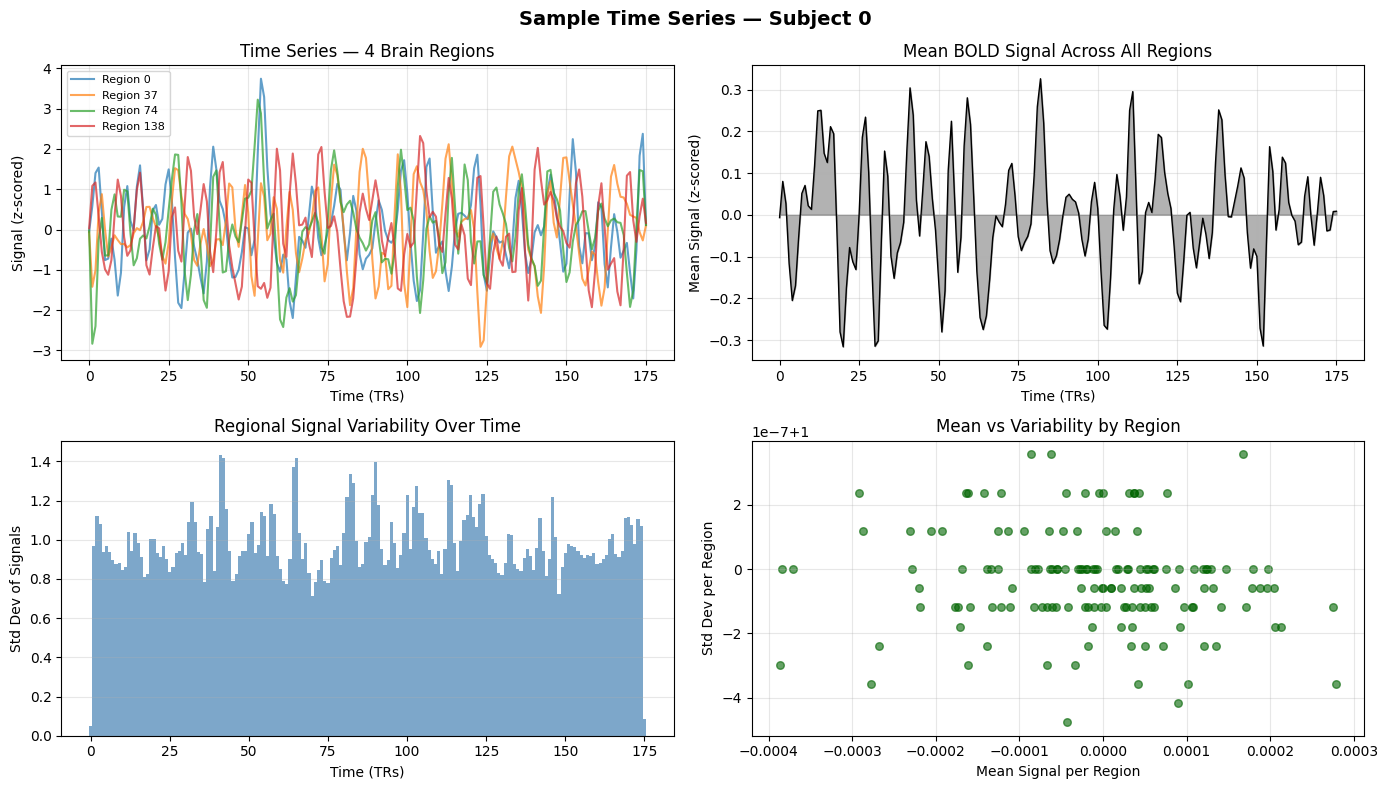

In [23]:
# Visualize Sample Time Series

print("Creating visualization of sample time series...")

sample_subject_ts  = all_time_series[0]
actual_n_regions   = sample_subject_ts.shape[1]

print(f"  Subject 0 shape: {sample_subject_ts.shape}")
print(f"  Actual regions:  {actual_n_regions}")

# Safe region indices based on actual size 
region_indices = [
    0,
    actual_n_regions // 4,
    actual_n_regions // 2,
    actual_n_regions - 10        # safe — always at least 10 from end
]
print(f"  Plotting regions: {region_indices}")

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle(
    'Sample Time Series — Subject 0',
    fontsize=14, fontweight='bold'
)

# Plot 1 — Time series from 4 regions
ax = axes[0, 0]
for region_idx in region_indices:
    ax.plot(
        sample_subject_ts[:, region_idx],
        label=f'Region {region_idx}',
        alpha=0.7
    )
ax.set_xlabel('Time (TRs)')
ax.set_ylabel('Signal (z-scored)')
ax.set_title('Time Series — 4 Brain Regions')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2 — Mean signal across all regions
ax = axes[0, 1]
mean_signal = sample_subject_ts.mean(axis=1)
ax.plot(mean_signal, linewidth=1, color='black')
ax.fill_between(
    range(len(mean_signal)),
    mean_signal,
    alpha=0.3, color='black'
)
ax.set_xlabel('Time (TRs)')
ax.set_ylabel('Mean Signal (z-scored)')
ax.set_title('Mean BOLD Signal Across All Regions')
ax.grid(True, alpha=0.3)

# Plot 3 — Standard deviation over time
ax = axes[1, 0]
std_across_regions = sample_subject_ts.std(axis=1)
ax.bar(
    range(len(std_across_regions)),
    std_across_regions,
    width=1, color='steelblue', alpha=0.7
)
ax.set_xlabel('Time (TRs)')
ax.set_ylabel('Std Dev of Signals')
ax.set_title('Regional Signal Variability Over Time')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4 — Mean vs variability scatter
ax = axes[1, 1]
region_means = sample_subject_ts.mean(axis=0)
region_stds  = sample_subject_ts.std(axis=0)
ax.scatter(region_means, region_stds, alpha=0.6, s=30, color='darkgreen')
ax.set_xlabel('Mean Signal per Region')
ax.set_ylabel('Std Dev per Region')
ax.set_title('Mean vs Variability by Region')
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
figures_dir = Path(config['figures_dir'])
figures_dir.mkdir(parents=True, exist_ok=True)
plot_path   = figures_dir / 'sample_time_series.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n Visualization saved to {plot_path}")
plt.show()

In [26]:
# Summary Statistics

print("=" * 80)
print("BRAIN SIGNAL EXTRACTION SUMMARY")
print("=" * 80)

print(f"\nDataset:")
print(f"  Subjects:          {n_subjects}")
print(f"  Brain regions:     {actual_n_regions}")
print(f"  TR:                {tr} seconds")

print(f"\nSignal Processing:")
print(f"  Standardization:   Enabled (z-score)")
print(f"  Detrending:        Enabled")
print(f"  High-pass filter:  0.01 Hz")
print(f"  Low-pass filter:   0.1 Hz")
print(f"  Confound removal:  Motion parameters")

print(f"\nResults:")
timepoints_list = [ts.shape[0] for ts in all_time_series]
print(f"  Total timepoints:  {sum(timepoints_list)}")
print(f"  Range per subject: {min(timepoints_list)}–{max(timepoints_list)}")
print(f"  Mean per subject:  {np.mean(timepoints_list):.1f}")

print(f"\nOutput Files:")
print(f"  Time series:   {output_path}")
print(f"  Visualization: {plot_path}")

print(f"\n Next step — Functional Connectivity")

BRAIN SIGNAL EXTRACTION SUMMARY

Dataset:
  Subjects:          20
  Brain regions:     148
  TR:                2.5 seconds

Signal Processing:
  Standardization:   Enabled (z-score)
  Detrending:        Enabled
  High-pass filter:  0.01 Hz
  Low-pass filter:   0.1 Hz
  Confound removal:  Motion parameters

Results:
  Total timepoints:  3370
  Range per subject: 77–261
  Mean per subject:  168.5

Output Files:
  Time series:   c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\data\all_time_series.npy
  Visualization: c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\sample_time_series.png

 Next step — Functional Connectivity
